##### 개요: 오늘 여러분은 Chicago시의 공중보건부에서 진행한 레스토랑들의 위생 검사 "불합격" 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [ ]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install xgboost==1.7.2
    
    #pdpdbox 설치 후 런타임을 꼭 다시 실행시켜주세요!!
    !pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.7.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [ ]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

train_url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv"
test_url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv"

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape == (20000, 17)

In [ ]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


# Part 1 - Data Preprocessing

In [ ]:
test["Inspection Fail"]

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: Inspection Fail, Length: 20000, dtype: int64

## 컬럼 설명

- **DBA**: 설립 시 서류에 등록한 이름

- **AKA**: 대중들에게 알려져 있는 상표 이름

- **License number**: 사업자 고유번호 (사업자등록번호)

- **Type of facility**: 매장 업종 

    bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2-6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.
    
    
- **Risk**: 위험 시설 분류 카테고리 : 국민 건강에 악영향을 미칠 위험이 얼마나 높은 시설인가? (1이 가장 높고, 3이 가장 낮은 카테고리임. 위험 1 시설이 검사 빈도가 높은 편이고, 위험 3 시설이 검사 빈도가 낮은 편)

- **Address, City, State, Zip**: 해당 시설이 위치한 주소 (Full Address)

- **Inspection date**: 검사 날짜. (어떤 사업장은 동일한 사업장명에 각기 다른 검사 날짜를 가지고 있을 수도 있음)

- **Inspection type**: 검사 유형. (각 이유에 대해 Re-inspection이 붙으면 재검사한 것)
    - Canvass : 시설의 위험도와 관련된 가장 이란적인 유형의 검사. 
    - Consultation : 개업 전 소유자의 요청으로 검사를 수행.
    - Complaint : 민원 사항 발생 시 검사를 수행할 때.
    - License : 사업장의 영업허가서 발금 요건으로 검사를 할 때.
    - Suspect Food Poisoning : 사업장에서 식사 (민원 처리 된 특정 유형의 검사)로 인해 병에 걸렸다고 주장하는 1인 이상에게 검사를 할 때.
    - Task-force Inspection : 술집 또는 주점의 검사가 수행된 경우
    
- **Inspection Fail**: 검사 결과(불합격 여부)
    - 실패를 받는다고 해서 반드시 사업장 면허가 정지되는 것은 아님.
    
- **Violations**: 위반사항. 위반사항을 지칭하는 고유번호와 위반한 사항 및 시정 요건에 대한 설명이 주어짐.

## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요.
- 아래 기본적인 EDA 과정을 위해 필요한 몇몇 함수들을 완성하세요.
- 함수의 기능 및 입출력 형태는 함수 내의 주석을 따르세요.
- **아래 EDA 과정만으로는 데이터에 대한 통찰을 얻기에 부족합니다. 추가로 본인만의 EDA 과정을 꼭 수행해 보세요.**

In [ ]:
def analysis_on_features(df):
    """
    - eda_results라고 하는 새로운 데이터프레임에 아래의 정보들을 담아 반환하세요.
        - null_count: 입력 Pandas DataFrame의 column별 결측치의 수
        - num_unique_values: 입력 Pandas DataFrame의 unique한 값의 수
        - eda_results는 df의 column명을 index로 사용하는 데이터프레임입니다.

    - 데이터프레임에 중복되는 row가 있지는 않나요?
        - duplicated_rows에 중복되는 row 수를 담아 반환하세요.

    """
    eda_results = pd.DataFrame()
    eda_results["null_count"] = None
    eda_results["num_unique_values"] = None
    duplicated_rows = -1

    # YOUR CODE HERE
    
    eda_results = pd.DataFrame(index=df.columns)
    eda_results['null_count'] = df.isnull().sum()
    eda_results['num_unique_values'] = df.nunique()

    duplicated_rows = df.duplicated().sum()
    
    # YOUR CODE ENDS HERE

    return eda_results, duplicated_rows

In [ ]:
train_results, train_duplicated_rows = analysis_on_features(train)
test_results, test_duplicated_rows = analysis_on_features(test)

In [ ]:
print(f"Train df: duplicated? = {train_duplicated_rows}\n", train_results, "\n\n")
print(f"Test df: duplicated? = {test_duplicated_rows}\n", test_results)

Train df: duplicated? = 0
                  null_count  num_unique_values
Inspection ID             0              60000
DBA Name                  0              20175
AKA Name                717              19209
License #                 4              25123
Facility Type          1427                366
Risk                     24                  4
Address                   0              15244
City                     45                 39
State                    15                  3
Zip                      13                 86
Inspection Date           0               2667
Inspection Type           0                 55
Violations            15870              44035
Latitude                178              14533
Longitude               178              14533
Location                178              14533
Inspection Fail           0                  2 


Test df: duplicated? = 0
                  null_count  num_unique_values
Inspection ID             0              20000
DBA 

In [ ]:
import matplotlib.pyplot as plt


def analysis_on_target(df):
    """
    n_zero_label, n_one_label에
    각각 label이 0인 데이터의 수, label이 1인 데이터의 수를 담아 반환하세요.
    """
    n_zero_label, n_one_label = -1, -1

    # YOUR CODE HERE
    
    n_zero_label = df['Inspection Fail'].value_counts()[0]
    n_one_label = df['Inspection Fail'].value_counts()[1]
    
    # YOUR CODE ENDS HERE

    plt.pie(
        (n_zero_label, n_one_label),
        labels=(0, 1),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: Inspection Fail", size=15)
    plt.show()

    return n_zero_label, n_one_label

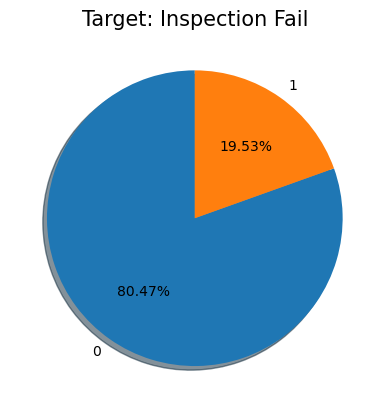

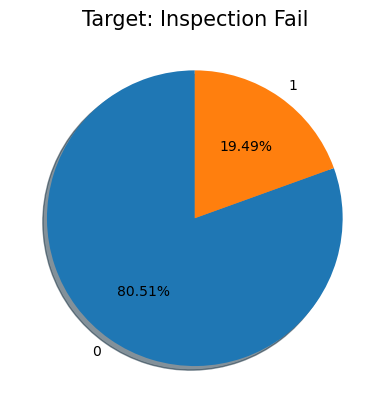

In [ ]:
train_label_count = analysis_on_target(train)
test_label_count = analysis_on_target(test)

In [ ]:
print(
    """
이 셀에서 추가로 데이터를 자유롭게 분석해 보세요.
- 이 셀에서의 작업은 채점하지 않습니다.
- 채점 시 이 셀에서 작업한 내용은 전부 무시됩니다.
- 제출 전에 이 셀의 내용을 모두 주석 처리한 후 모든 코드가 순차적으로 오류 없이 실행되는지 꼭 확인하세요.
"""
)

train.info()


이 셀에서 추가로 데이터를 자유롭게 분석해 보세요.
- 이 셀에서의 작업은 채점하지 않습니다.
- 채점 시 이 셀에서 작업한 내용은 전부 무시됩니다.
- 제출 전에 이 셀의 내용을 모두 주석 처리한 후 모든 코드가 순차적으로 오류 없이 실행되는지 꼭 확인하세요.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    60000 non-null  int64  
 1   DBA Name         60000 non-null  object 
 2   AKA Name         59283 non-null  object 
 3   License #        59996 non-null  float64
 4   Facility Type    58573 non-null  object 
 5   Risk             59976 non-null  object 
 6   Address          60000 non-null  object 
 7   City             59955 non-null  object 
 8   State            59985 non-null  object 
 9   Zip              59987 non-null  float64
 10  Inspection Date  60000 non-null  object 
 11  Inspection Type  60000 non-null  object 
 12  Violations       44130 non-null  object 
 13  Latitude         59822 non-null  float64
 14  L

In [ ]:
# 범주형 변수 확인

object_cols = ['Facility Type', 'Risk', 'City', 'State', 'Inspection Type', 'Violations']

for col in object_cols:
    print(f'col name : {col}')
    print(train[col].value_counts(normalize=True))
    print("--------------")

col name : Facility Type
Restaurant                      0.681577
Grocery Store                   0.134243
School                          0.061547
Children's Services Facility    0.016970
Bakery                          0.014358
                                  ...   
blockbuster video               0.000017
ICE CREAM PARLOR                0.000017
CONVNIENCE STORE                0.000017
BAR                             0.000017
CLOTHING STORE                  0.000017
Name: Facility Type, Length: 366, dtype: float64
--------------
col name : Risk
Risk 1 (High)      0.714269
Risk 2 (Medium)    0.196028
Risk 3 (Low)       0.089502
All                0.000200
Name: Risk, dtype: float64
--------------
col name : City
CHICAGO                 0.996931
Chicago                 0.001351
chicago                 0.000600
CCHICAGO                0.000150
ELK GROVE VILLAGE       0.000083
SCHAUMBURG              0.000067
INACTIVE                0.000067
CICERO                  0.000067
MAYWOOD   


## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 수행하는 함수 `eda_process`를 작성하세요.

- 결측치를 적절히 처리하세요.
    - **Row를 drop하지 말고, 적절한 값으로 채워넣어 보세요.**
    - 전처리가 완료된 train, test 데이터의 크기는 각각 **59947, 19994**입니다.
- 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다.
- 시간 배분을 고려하여 적절한 수준으로 수행하세요!

In [ ]:
# import any libraries needed
# YOUR CODE HERE
from sklearn.impute import SimpleImputer

# YOUR CODE ENDS HERE


def eda_process(df):
    # State 컬럼 처리 : 결측치 및 IL이 아닌 row 삭제
    df.dropna(subset=["State"], how="any", axis=0, inplace=True)
    df = df.query("State == 'IL'")

    # Risk : 결측치 및 All 삭제 > 1, 2, 3으로 바꾸어 줌
    df.dropna(subset=["Risk"], how="any", axis=0, inplace=True)
    df = df.query("Risk != 'All'")
    df.replace("Risk 1 (High)", 1, inplace=True)
    df.replace("Risk 2 (Medium)", 2, inplace=True)
    df.replace("Risk 3 (Low)", 3, inplace=True)

    # YOUR CODE HERE

    # 불필요한 컬럼 삭제
    df.drop(columns=['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Location', 'State', 'Address'], inplace=True)

    # City  카디널리티 정리
    city_list =[]
    for row in df.City:
      a = str(row)
      a = a.upper()
      city_list.append(a)
    df['City'] = city_list

    city_list2 = []
    for row in df.City:
      if 'CAGO' in row:
        city_list2.append('CHICAGO')
      elif 'cago' in row:
        city_list2.append('CHICAGO')
      else:
        city_list2.append('ETC')
    df['City'] = city_list2


    # Facility Type 카디널리티 정리
    facilities = ['bakery', 'banquet hall', 'candy store', 'caterer', 'coffee shop', 'day care center', 'gas station', 'golden diner', 'grocery store', 'hospital',
                  'long term care center', 'liquor store', 'mobile food dispenser', 'restaurant', 'paleteria', 'school', 'shelter', 'social club', 'wholesaler', 'wrigley field rooftop']

    facil_list = []
    for row in df['Facility Type']:
      row = str(row)
      row = row.lower()
      facil_list.append(row)
    df['Facility Type'] = facil_list

    factype_list = []
    for row in df['Facility Type']:
      if row in facilities:
        factype_list.append(row)
      elif 'daycare' in row :
        factype_list.append('day care center')
      elif 'children' in row :
        factype_list.append('day care center')
      elif 'care' in row :
        factype_list.append('day care center')
      elif 'term' in row :
        factype_list.append('long term care center')
      elif 'liquor' in row : 
        factype_list.append('liquor store')
      elif 'nan' in row :
        factype_list.append('etc')
      elif 'wholesale' in row :
        factype_list.append('wholesaler')
      elif 'catering' in row :
        factype_list.append('caterer')
      elif 'mobile' in row :
        factype_list.append('mobile food dispenser')
      elif 'tavern' in row :
        factype_list.append('social club')
      elif 'event' in row :
        factype_list.append('caterer')
      elif 'bar' in row :
        factype_list.append('social club')
      elif 'banquet' in row :
        factype_list.append('banquet hall')
      elif 'grocery' in row :
        factype_list.append('grocery store')
      elif 'cafeteria' in row :
        factype_list.append('school')
      elif 'school' in row:
        factype_list.append('school')
      elif 'coffee' in row:
        factype_list.append('coffee shop')
      elif 'rooftop' in row:
        factype_list.append('wrigley field rooftop')
      elif 'convenience store' in row :
        factype_list.append('etc')
      elif 'store' in row :
        factype_list.append('grocery store')
      elif 'paleteria' in row :
        factype_list.append('paleteria')
      elif 'commissary' in row :
        factype_list.append('shelter')
      elif 'candy' in row :
        factype_list.append('candy store')
      elif 'roof' in row :
        factype_list.append('wrigley field rooftop')
      elif 'brewery' in row :
        factype_list.append('social club')
      elif 'restaurant' in row :
        factype_list.append('restaurant')
      elif 'old' in row :
        factype_list.append('day care center')
      elif 'child' in row :
        factype_list.append('day care center')
      elif 'pub' in row :
        factype_list.append('social club')
      elif 'donut' in row :
        factype_list.append('bakery')
      elif 'nursing' in row :
        factype_list.append('long term care center')
      elif 'gas' in row :
        factype_list.append('gas station')
      elif 'bakery' in row :
        factype_list.append('bakery')
      elif 'college' in row :
        factype_list.append('school')
      else:
        factype_list.append('etc')
        
    df['Facility Type'] = factype_list


    # Inspection Type 카디널리티 정리

    inspections = ['Canvass', 'Canvass Re-Inspection', 'Consultation', 'Consultation Re-Inspection', 'Complaint', 'Complaint Re-Inspection', 'License', 'License Re-Inspection', 
                  'Suspect Food Poisoning', 'Suspect Food Poisoning Re-Inspection', 'Task-force Inspection', 'Task-force Inspection Re-Inspection']

    instype_list = []
    for row in df['Inspection Type']:
      if row in inspections :
        instype_list.append(row)
      else :
        if 'Complaint' in row:
          instype_list.append('Complaint')
        elif 'COMPLAINT' in row:
          instype_list.append('Complaint')
        elif 'Poisoning' in row:
          instype_list.append('Suspect Food Poisoning')
        elif 'License' in row:
          instype_list.append('License')
        elif 'LICENSE' in row:
          instype_list.append('License')
        elif 'Force' in row:
          instype_list.append('Task-force Inspection')
        elif 'force' in row:
          instype_list.append('Task-force Inspection')
        elif 'FORCE' in row:
          instype_list.append('Task-force Inspection')
        elif 'CANVASS' in row:
          instype_list.append('Canvass')
        elif 'Liquor' in row:
          instype_list.append('Task-force Inspection')
        elif 'Ready' in row:
          instype_list.append('Consultation')
        elif 'Out of Business' in row:
          instype_list.append('No Business')
        elif 'OUT OF BUSINESS' in row:
          instype_list.append('No Business')
        elif 'KITCHEN CLOSED FOR RENOVATION' in row:
          instype_list.append('No Business')
        elif 'REINSPECTION' in row:
          instype_list.append('Canvass Re-Inspection')
        elif 'POSSIBLE FBI' in row:
          instype_list.append('Task-force Inspection')
        elif 'Re' in row:
          instype_list.append('Canvass Re-Inspection')
        else:
          instype_list.append('Canvass')

    df['Inspection Type'] = instype_list


    # Inpection Date 컬럼을 year, month로 분리

    year_list = []
    month_list = []
    
    for row in df['Inspection Date']:
      year = int(row[:4])
      month = int(row[5:7])

      year_list.append(year)
      month_list.append(month)
    
    df['Inspection Year'] = year_list
    df['Inspection Month'] = month_list
    
    # index reset
    df.reset_index(inplace=True)
    
    # Violations, Zip 결측치 채우기
    df.fillna(0, inplace=True)

    # Zip 데이터타입 변경
    df['Zip'] = df['Zip'].astype('int')
 

    # Violation 위반사항 숫자만 남기기
    violation_list = []

    for row in df['Violations']:
      if row == 0:
        violation_list.append(0)
      
      else:
        viols = row.split('|')
        row_list = []
        for viol in viols:
          viol = str(viol).strip()
          num = viol[:2]

          if '.' in num:
            num = num.replace('.','')
            row_list.append(num)
          else : 
            row_list.append(num)
        violation_list.append(row_list)

    df['Violations'] = violation_list


    # Violation 갯수 컬럼 생성

    violnum_list = []


    for i in df['Violations']:
      if i == 0 :
        violnum_list.append(0)
      else:
        violnum_list.append(len(i))
    
    df['Violation Num'] = violnum_list

    # violations 번호별 위반 여부 컬럼 생성
    
    # violation 정보만 모을 데이터프레임 생성
    viol_data = pd. DataFrame(index=range(len(df)))
  
    # viol_data에 들어갈 컬럼 생성
    for i in range(70):
        num = str(i + 1)
        col_name = 'Violation ' + num
        viol_data[col_name] = [0] * len(df)

    for idx, row in df['Violations'].iteritems() :
        if row == 0 :
            continue
        else :
          for errCode in row :
            col = 'Violation ' + errCode
            viol_data.loc[idx, col] = 1
    
    # 데이터프레임 concat
    df = pd.concat([df, viol_data], axis=1)    

    # 전처리 후 불필요한 컬럼 삭제
    df.drop(columns=['Inspection Date', 'Violations', 'index'], inplace=True)

    # YOUR CODE ENDS HERE

    return df

In [ ]:
train_processed = eda_process(train.copy())
test_processed = eda_process(test.copy())
print(train_processed.shape, test_processed.shape)
assert len(train_processed) == 59947, "train data 전처리가 잘못되었습니다. 조건을 다시 확인하세요."
assert len(test_processed) == 19994, "test data 전처리가 잘못되었습니다. 조건을 다시 확인하세요."

(59947, 81) (19994, 81)


In [ ]:
# EDA 결과 확인
train_processed

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Inspection Fail,Inspection Year,Inspection Month,...,Violation 61,Violation 62,Violation 63,Violation 64,Violation 65,Violation 66,Violation 67,Violation 68,Violation 69,Violation 70
0,restaurant,1,CHICAGO,60614,Canvass,41.927577,-87.651528,0,2017,5,...,0,0,0,0,0,0,0,0,0,0
1,restaurant,2,CHICAGO,60603,Canvass,41.881807,-87.629543,0,2017,8,...,0,0,0,0,0,0,0,0,0,0
2,restaurant,1,CHICAGO,60601,Complaint,41.886377,-87.624382,0,2015,12,...,0,0,0,0,0,0,0,0,0,0
3,restaurant,1,CHICAGO,60614,Canvass,41.914990,-87.654994,0,2012,7,...,0,0,0,0,0,0,0,0,0,0
4,restaurant,1,CHICAGO,60616,Canvass,41.858996,-87.624106,0,2013,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59942,day care center,1,CHICAGO,60643,License,41.706982,-87.647758,0,2019,10,...,0,0,0,0,0,0,0,0,0,0
59943,grocery store,3,CHICAGO,60623,License Re-Inspection,41.851324,-87.732192,0,2012,8,...,0,0,0,0,0,0,0,0,0,0
59944,restaurant,1,CHICAGO,60618,Complaint,41.954067,-87.701753,0,2012,4,...,0,0,0,0,0,0,0,0,0,0
59945,restaurant,1,CHICAGO,60659,License,41.997876,-87.687764,0,2016,2,...,0,0,0,0,0,0,0,0,0,0


### 전처리 후 target 분포의 변화를 다시 확인해 보세요.

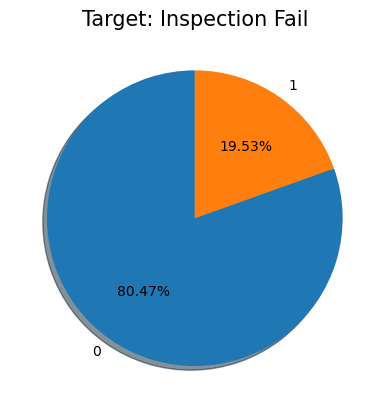

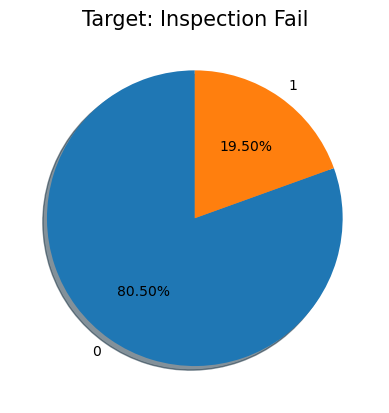

(16096, 3898)

In [ ]:
analysis_on_target(train_processed)
analysis_on_target(test_processed)

# Part 2 - Modeling

## 2.1 데이터를 feature (X), label(y)로 분할하는 `divide_data` 함수를 작성하세요.
- Target Column은 `Inspection Fail`입니다.

In [ ]:
def divide_data(df):
    X = None
    y = None

    # YOUR CODE HERE
    target = 'Inspection Fail'
    X = df.drop(target, axis=1)
    y = df[target]
    
    # YOUR CODE ENDS HERE

    return X, y

In [ ]:
X_train, y_train = divide_data(train_processed)
X_test, y_test = divide_data(test_processed)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(59947, 80) (59947,) (19994, 80) (19994,)


## 2.2 모델을 생성하고 학습하는 `fit` 함수와 1일 확률을 반환하는 `predict` 함수를 작성하세요. 
- Scikit-learn의 `pipeline`을 활용하여 학습 파이프라인을 생성하세요.
- Boosting 모델을 사용하고자 할 경우 XGBoost를 사용하세요.
- `RandomizedSearchCV`를 사용해 CV를 진행하세요.
    - 적어도 두 개 이상의 하이퍼파라미터에 대해 탐색을 진행하세요.
    - **AUC score를 최대화하는 하이퍼파라미터 조합을 선택하세요.**
- cv는 5 이하, n_iter은 10회 이하로 하세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# import any libraries needed
# YOUR CODE HERE

from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
# YOUR CODE ENDS HERE


def fit(X_train, y_train):
    pipeline = None  # pipeline = make_pipeline(...)
    clf = None  # clf = RandomizedSearchCV(pipeline, ...)

    # YOUR CODE HERE

    from category_encoders import OrdinalEncoder

    pipeline = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier()
    )

    params = {
    "xgbclassifier__max_depth": [12, 13, 14, 15, 16],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.15, 0.2]
    }

    clf = RandomizedSearchCV(
        pipeline,
        params,
        scoring='roc_auc',
        error_score="raise",
        n_iter=5,
        cv=3,
        random_state=2
    )
    
    
    # YOUR CODE ENDS HERE

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf


def predict(X, y, best_estimator):
    y_pred_proba = None

    # YOUR CODE HERE

    y_pred_proba = best_estimator.predict_proba(X)[:,1]
    
    
    # YOUR CODE ENDS HERE

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

In [ ]:
clf = fit(X_train, y_train)

Optimal Hyperparameter: {'xgbclassifier__max_depth': 16, 'xgbclassifier__learning_rate': 0.1}
AUC: 0.9804416869087564


### 아래 셀을 실행시켜 모델의 Test score을 확인해 보세요.
- auc_score > 0.65을 만족하면 기본 성능점수를 얻습니다.
- (도전과제) auc_score > 0.75을 만족하면 성능점수 만점을 얻습니다.
    - 도전과제까지 수행해야 스챌 3점을 얻습니다. 
    - 1.2으로 돌아가 다양한 특성 조합을 시도해 보세요. 
    - 2.2로 돌아가 SearchCV에서 다양한 하이퍼파라미터 옵션 조합을 선택해 보세요.
        - 본인이 선택한 모델에서, 각 하이퍼파라미터가 어떤 의미를 가지나요?
        - SearchCV가 더 다양한 하이퍼파라미터 조합을 시도하도록 하기 위해 SearchCV의 어떤 옵션을 조정해야 할까요?

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     16096
           1       0.88      0.84      0.86      3898

    accuracy                           0.95     19994
   macro avg       0.92      0.91      0.91     19994
weighted avg       0.95      0.95      0.95     19994



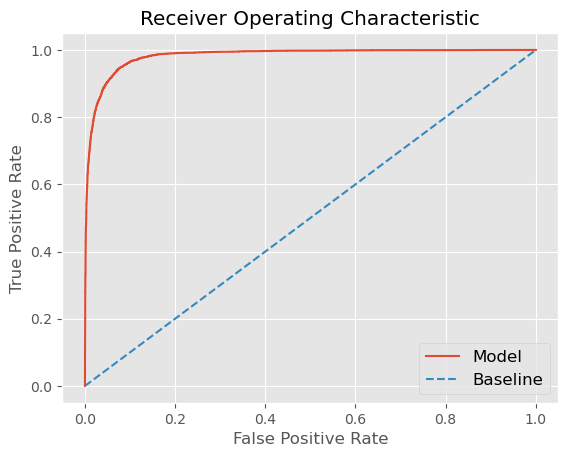

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [ ]:
print("Test AUC:", auc_score)

Test AUC: 0.9822173137419709


In [ ]:
print("Test AUC > 0.75?:", auc_score > 0.75)

Test AUC > 0.75?: True


# Part 3 - Visualization
- `eli5`의 `PermutationImportance`, `pdpbox` 등의 라이브러리에서는 이미 전처리가 완료되어 수치형 자료로 변환된 독립변수들을 입력으로 받습니다.
- 따라서, 2.2에서 생성한 pipeline을 **전처리를 위한 부분**과 **예측 모델**로 나눠 주어야 합니다.
    - 전처리를 위한 부분을 거친 후에는 모든 특성들이 수치형이어야 합니다. 
- 아래 셀에서 해당 과정을 수행해 주세요.
    1. `pipeline`을 `preprocess_pipeline`과 `model`로 나눠 주세요.
    2. `preprocess_pipeline`으로 `X_test`를 transform하여 `X_test_preprocessed`를 생성하세요.

In [ ]:
pipeline = clf.best_estimator_

# TODO: pipeline을 preprocess_pipeline과 model로 나눠 주세요.
preprocess_pipeline = None
model = None
# YOUR CODE HERE

from category_encoders import OrdinalEncoder

preprocess_pipeline = OrdinalEncoder()
model = XGBClassifier(max_depth=14,
                     learning_rate=0.1)
X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
model.fit(X_train_preprocessed, y_train)

# YOUR CODE ENDS HERE

# TODO: X_test를 preprocess_pipeline에 통과시켜 X_test_preprocessed를 만드세요.
X_test_preprocessed = None
# YOUR CODE HERE
X_test_preprocessed = preprocess_pipeline.transform(X_test)
# YOUR CODE ENDS HERE

## 3.1 Permutation Importance를 계산하는 `get_permutation_importance` 함수를 작성하세요.
- AUC score을 기준으로 Permutation Importance를 계산하는 permuter을 생성, fit하여 반환하세요.
- `n_iter=5`로 하세요.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance


def get_permutation_importance(X, y, model):
    permuter = None
    # permuter = PermutationImportance(..., n_iter=5, random_state=42)

    # YOUR CODE HERE
    permuter = PermutationImportance(model,
                                     scoring = 'roc_auc',
                                     n_iter=10,
                                     random_state=2)
    
    
    # YOUR CODE ENDS HERE
    permuter.fit(X, y)

    return permuter

In [ ]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:3])

Top3 Important Features:
[('Violation 18', 0.14485462800416574), ('Inspection Type', 0.05324691872495141), ('Violation 29', 0.04465092621541139)]


### 위 결과를 기반으로, 아래의 질문에 답해 보세요. 
- 확인할 수 없으면 `"모름"`으로 답하세요.
- 답이 하나이면 `String`, 여러 개이면 `List`로 답하세요.


- **문제 1.** 모델의 성능에 가장 많은 영향을 주는 특성은 무엇인가요?
- **문제 2.** 모델의 예측값과 양의 상관관계를 갖는 특성은 무엇인가요?
- **문제 3.** 모델의 예측값과 음의 상관관계를 갖는 특성은 무엇인가요?


In [ ]:
answer_1 = None
answer_2 = None
answer_3 = None

# YOUR CODE HERE

p_i_data = pd.DataFrame(p_i)

answer_1 = 'Violation 18'
answer_2 = p_i_data[p_i_data[1] < 0][0].tolist()
answer_3 = p_i_data[p_i_data[1] > 0][0].tolist()

# YOUR CODE ENDS HERE

In [ ]:
print("A1:", answer_1)
print("A2:", answer_2)
print("A3:", answer_3)


A1: Violation 18
A2: ['Violation 4', 'Violation 64', 'Violation 6', 'Violation 57', 'Violation 44', 'Violation 53', 'Violation 56', 'Violation 40', 'City', 'Violation 45']
A3: ['Violation 18', 'Inspection Type', 'Violation 29', 'Inspection Year', 'Violation 19', 'Violation 24', 'Violation Num', 'Violation 16', 'Violation 11', 'Violation 26', 'Violation 38', 'Violation 22', 'Violation 14', 'Violation 10', 'Violation 9', 'Violation 13', 'Violation 21', 'Violation 2', 'Violation 59', 'Facility Type', 'Violation 48', 'Latitude', 'Violation 60', 'Violation 34', 'Inspection Month', 'Violation 54', 'Longitude', 'Zip', 'Violation 8', 'Violation 32', 'Violation 50', 'Violation 35', 'Violation 25', 'Risk', 'Violation 33', 'Violation 12', 'Violation 27', 'Violation 5', 'Violation 58', 'Violation 23', 'Violation 41', 'Violation 55', 'Violation 52', 'Violation 47', 'Violation 30', 'Violation 36', 'Violation 3', 'Violation 37', 'Violation 39', 'Violation 1', 'Violation 51', 'Violation 43', 'Violatio

## 3.2 1변수 PDP를 생성하는 `get_pdp_isolated` 함수를 작성하세요.
- `feature`의 특성을 변수로 하는 1변수 PDP를 생성합니다.

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    # YOUR CODE HERE

    target_feature = feature

    pdp_isolated = pdp_isolate(
        model=model,
        dataset=dataset,
        model_features=X_test.columns,
        feature=feature,
        grid_type="percentile",
        num_grid_points=10, 
    )
    
    # YOUR CODE ENDS HERE

    return pdp_isolated

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <Axes: >, 'pdp_ax': <Axes: xlabel='Violation 18'>})

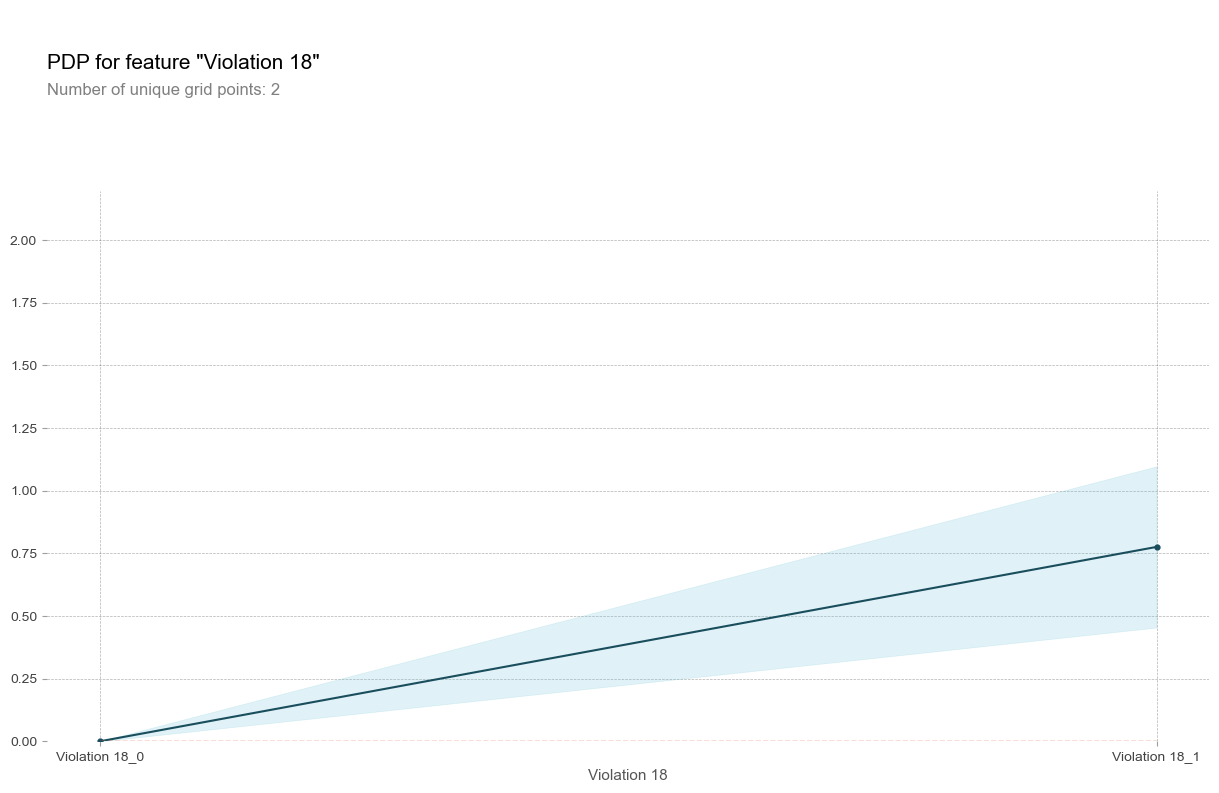

In [ ]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

### 위 결과를 기반으로, 아래의 질문에 답해 보세요. 
- `True`/`False`로 답하고 그 이유를 한 줄로 작성하세요.


- **문제 1.** 위 Plot은 해당 특성에 따른 실제 label 값의 양상을 나타낸 것이다.
- **문제 2.** 위 Plot은 해당 특성에 따른 모델의 label 예측값의 양상을 나타낸 것이다.
- **문제 3.** 단순/다중 선형회귀 모델에서 isolated PDP는 데이터의 분포와는 무관하게 항상 직선이다.
- **문제 4.** 단순/다중 선형회귀 모델의 isolated PDP에서 여러 개의 서로 다른 ICE 곡선이 나올 수 있다.


In [ ]:
answer_1 = False  # True / False
reason_1 = ""
answer_2 = False  # True / False
reason_2 = ""
answer_3 = False  # True / False
reason_3 = ""
answer_4 = False  # True / False
reason_4 = ""

# YOUR CODE HERE

answer_1 = False  # True / False
reason_1 = "실제가 아닌 예측값이 될 확률을 나타낸 것이다"
answer_2 = True  # True / False
reason_2 = ""
answer_3 = True  # True / False
reason_3 = ""
answer_4 = False  # True / False
reason_4 = "모든 값이 회귀선으로 회귀하기 때문이다"
# YOUR CODE ENDS HERE

In [ ]:
print("A1:", answer_1, "Why?:", reason_1)
print("A2:", answer_2, "Why?:", reason_2)
print("A3:", answer_3, "Why?:", reason_3)
print("A4:", answer_4, "Why?:", reason_4)


A1: False Why?: 실제가 아닌 예측값이 될 확률을 나타낸 것이다
A2: True Why?: 
A3: True Why?: 
A4: False Why?: 모든 값이 회귀선으로 회귀하기 때문이다


## 3.3 2변수 PDP를 생성하는 `get_pdp_interaction` 함수를 작성하세요.

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot


def get_pdp_interaction(dataset, model, features):
    pdp_interaction = None

    # YOUR CODE HERE
    
    pdp_interaction = pdp_interact(
        model=model,
        dataset=dataset,
        model_features=dataset.columns,
        features=features
    )
    
    
    # YOUR CODE ENDS HERE

    return pdp_interaction

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <Axes: >,
  'pdp_inter_ax': <Axes: xlabel='Violation 18', ylabel='Inspection Type'>})

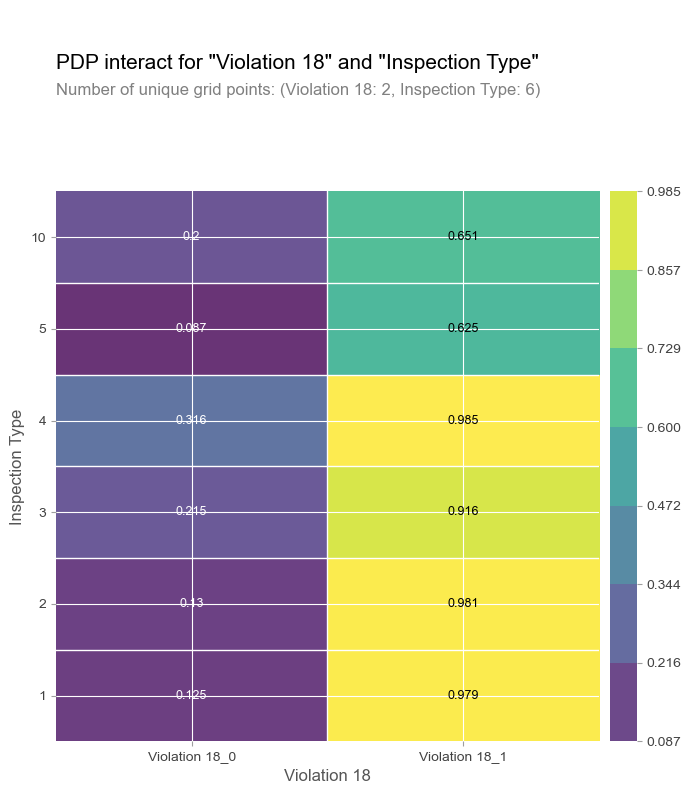

In [ ]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")

---

# 수고하셨습니다!